# 序列召回基础

## 0. 前言

备忘：<br/>
1. 需要了解一下非多兴趣模型和多兴趣模型。
2. 借这个机会，把recall召回率吃透吧。
3. 多层感知机等基础知识复习。

<br/>

引用资料 <br/>
0. 本课程项目：[https://aistudio.baidu.com/aistudio/course/introduce/27783?directly=1&shared=1](http://) <br/>
1. 一个关于Embedding的介绍：https://zhuanlan.zhihu.com/p/46016518 <br/>
2. 另一个关于Embedding的介绍：https://www.zhihu.com/question/38002635 <br/>
3. 协同过滤 https://www.bilibili.com/video/BV164411b7dx <br/>
4. RNN和LSTM的基础：https://zhuanlan.zhihu.com/p/32085405 <br/>
5. GRU的一些介绍：https://www.zhihu.com/search?type=content&q=GRU <br/>
6. 关于cpu().detach().numpy()的用法：[https://blog.csdn.net/qq_39938666/article/details/90794240](http://) <br/>


## 1. 序列召回基础

### 1.1 推荐系统基础

![](https://ai-studio-static-online.cdn.bcebos.com/fa1b375c169144bd9c19d79497e6d8579dec993c90864b00afc52c77276b1939)



| 阶段 | 作用 |特点|
| -------- | -------- |--------| 
| 物料库     | 存储所有items     |ALL|
| 召回    | 让用户感兴趣的物品在此阶段快速召回|候选集合大、计算速度快、模型简单、特征较少 |
| 精排     | 得到精确的排序结果     |处理的物品少、特征较多、模型较为复杂|
| 重排     | 避免排序阶段结果同质化，对其进行多样化考虑，提高用户体验     |/|





### 1.2 推荐系统中的召回



| 算法 | 特点 |
| -------- | -------- |
| 基于规则     | 使用运行规则，例如找回点击次数最多、购买次数最多、购买金额最多的item等    |
| 基于协同过滤    | 见吴恩达91—96视频 [https://www.bilibili.com/video/BV164411b7dx](http://)|
| 基于向量     | 不会😑，I2I和U2I    |

| 算法 | 特点 |
| -------- | -------- |
| I2I     | 用某种算法生产出item的向量表征，然后用相似度进行召回（use Faiss）    |
| U2I   | 通过User的历史序列提取User的向量表征，然后和item表征对齐，即序列召回🚀|





### 1.3 基于GRU4Rec的基础序列召回

RNN和LSTM的基础：[https://zhuanlan.zhihu.com/p/32085405](http://) <br/>
GRU的一些介绍：[https://www.zhihu.com/search?type=content&q=GRU](http://) <br/>
一个关于Embedding的介绍：https://zhuanlan.zhihu.com/p/46016518 <br/>
另一个关于Embedding的介绍：https://www.zhihu.com/question/38002635 <br/>

该懂的都懂了，不懂的，看缘分咯。





### 1.4 聊了聊embedding与模型训练

通过上面那些链接，终于明白了embedding相当于一种降维打击。所以作者可以用4维的向量去表征10个item中的item。下面换了个参数。

#### Embedding toy

embedding一下：
```
emb_layer = nn.Embedding(5,2)
index = paddle.to_tensor([1,2,3])

print(emb_layer.weight)
print(emb_layer(index))
```
输出：

```
Parameter containing:
Tensor(shape=[5, 2], dtype=float32, place=Place(cpu), stop_gradient=False,
       [[ 0.35040128,  0.09418511],
        [ 0.84312761, -0.78916132],
        [-0.69693363, -0.67288005],
        [-0.67841357,  0.61909926],
        [-0.48198530, -0.59461612]])
Tensor(shape=[3, 2], dtype=float32, place=Place(cpu), stop_gradient=False,
       [[ 0.84312761, -0.78916132],
        [-0.69693363, -0.67288005],
        [-0.67841357,  0.61909926]])

```
GRU特征提取：

⭐bingo！ 提取完成

得到了用户的向量表征之后，进行多分类损失计算，标签为用户下一次点击item的index。通过方法计算出user对所有item的点击概率后，用softmax进行多分类损失计算。巴拉巴拉一大串后训练模型，验证模型。


In [3]:
import paddle
from paddle import nn
from paddle.io import DataLoader, Dataset
import pandas as pd
import numpy as np
import copy
import os
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score,log_loss
from tqdm import tqdm
from collections import defaultdict
import math
import random
import warnings
warnings.filterwarnings("ignore")

emb_layer = nn.Embedding(5,2)
index = paddle.to_tensor([1,2,3])

print(emb_layer.weight)
print(emb_layer(index))

Parameter containing:
Tensor(shape=[5, 2], dtype=float32, place=Place(cpu), stop_gradient=False,
       [[ 0.35040128,  0.09418511],
        [ 0.84312761, -0.78916132],
        [-0.69693363, -0.67288005],
        [-0.67841357,  0.61909926],
        [-0.48198530, -0.59461612]])
Tensor(shape=[3, 2], dtype=float32, place=Place(cpu), stop_gradient=False,
       [[ 0.84312761, -0.78916132],
        [-0.69693363, -0.67288005],
        [-0.67841357,  0.61909926]])


## 2. 代码实践

In [4]:
!pip install faiss

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 3.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import paddle
from paddle import nn
from paddle.io import DataLoader, Dataset
import paddle.nn.functional as F
import pandas as pd
import numpy as np
import copy
import os
import math
import random
from sklearn.metrics import roc_auc_score,log_loss
from sklearn.preprocessing import normalize
from tqdm import tqdm
from collections import defaultdict
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import faiss
# paddle.device.set_device('gpu:0')
import warnings
warnings.filterwarnings("ignore")

### 2.1 Dataset

#### 代码分析 —— SequenceDataset(Dataset)

1. __init__ 里的都是常规操作，df是按user_id聚类时间排序后的,U2I和task1里面的方法一样，也是做成一个字典。user_list就是用户列表咯。
2. config['max_length'] 后面定义为了20
3. __getitem__(self, index)中的，k = random.choice(range(4, len(item_list)))生成了一个从8到item_list长度的数。而这个数，作为一个起始索引，如果k大于20，就从[k-20,k]选择20个item，同时将对应的mask都设为1。如果k小于20，就拿[0,k]的数，同时将对应的mask设为1，然后[k,20]对应的mask设为0。len_sequence = max_length。
4. 如果phase是训练集，就随机取k，如果是测试集，k就等于0.8* len(item_set)

In [6]:
class SeqnenceDataset(Dataset):
    def __init__(self, config, df, phase='train'):
        self.config = config
        self.df = df
        self.max_length = self.config['max_length']
        self.df = self.df.sort_values(by=['user_id', 'timestamp'])
        self.user2item = self.df.groupby('user_id')['item_id'].apply(list).to_dict()
        self.user_list = self.df['user_id'].unique()
        self.phase = phase

    def __len__(self, ):
        return len(self.user2item)

    def __getitem__(self, index):
        if self.phase == 'train':
            user_id = self.user_list[index]
            item_list = self.user2item[user_id]
            hist_item_list = []
            hist_mask_list = []

            k = random.choice(range(4, len(item_list)))  # 从[8,len(item_list))中随机选择一个index
            # k = np.random.randint(2,len(item_list))
            item_id = item_list[k]  # 该index对应的item加入item_id_list

            if k >= self.max_length:  # 选取seq_len个物品
                hist_item_list.append(item_list[k - self.max_length: k])
                hist_mask_list.append([1.0] * self.max_length)
            else:
                hist_item_list.append(item_list[:k] + [0] * (self.max_length - k))
                hist_mask_list.append([1.0] * k + [0.0] * (self.max_length - k))

            return paddle.to_tensor(hist_item_list).squeeze(0), paddle.to_tensor(hist_mask_list).squeeze(
                0), paddle.to_tensor([item_id])
        else:
            user_id = self.user_list[index]
            item_list = self.user2item[user_id]
            hist_item_list = []
            hist_mask_list = []

            k = int(0.8 * len(item_list))
            # k = len(item_list)-1

            if k >= self.max_length:  # 选取seq_len个物品
                hist_item_list.append(item_list[k - self.max_length: k])
                hist_mask_list.append([1.0] * self.max_length)
            else:
                hist_item_list.append(item_list[:k] + [0] * (self.max_length - k))
                hist_mask_list.append([1.0] * k + [0.0] * (self.max_length - k))

            return paddle.to_tensor(hist_item_list).squeeze(0), paddle.to_tensor(hist_mask_list).squeeze(
                0), item_list[k:]

    def get_test_gd(self):
        self.test_gd = {}
        for user in self.user2item:
            item_list = self.user2item[user]
            test_item_index = int(0.8 * len(item_list))
            self.test_gd[user] = item_list[test_item_index:]
        return self.test_gd


### 2.2 基础序列召回模型定义

#### 代码分析 —— GRU4Rec(nn.Layer)

1. __ init _ 中，embedding_dim 就是要embedding的维数，后面设置为了16。n_items 是一万多。item_emb = nn.Embedding(self.n_items, self.embedding_dim, padding_idx=0)，是对这一万多 items 进行 embedding 到16维的操作。gru是GRU实例化的一个对象，input_size，hidden_size都等于embedding_dim。
2. calculate_loss：item_emb.weight 是所有的降维后的item，具体可以参考上面的toy
3. forward函数里，实际就是先将item的embedding放进GRU中，这个GRU是已经被封装好的了，然后将返回值，也就是注释中写到的，GRU输出的最后一个Hidden作为User的Embedding。


In [4]:
class GRU4Rec(nn.Layer):
    def __init__(self, config):
        super(GRU4Rec, self).__init__()

        self.config = config
        self.embedding_dim = self.config['embedding_dim']
        self.max_length = self.config['max_length']
        self.n_items = self.config['n_items']
        self.num_layers = self.config['num_layers']

        self.item_emb = nn.Embedding(self.n_items, self.embedding_dim, padding_idx=0)
        self.gru = nn.GRU(
            input_size=self.embedding_dim,
            hidden_size=self.embedding_dim,
            num_layers=self.num_layers,
            time_major=False,
        )
        self.loss_fun = nn.CrossEntropyLoss()
        self.reset_parameters()

    def calculate_loss(self,user_emb,pos_item):
        all_items = self.item_emb.weight
        scores = paddle.matmul(user_emb, all_items.transpose([1, 0]))
        return self.loss_fun(scores,pos_item)

    def output_items(self):
        return self.item_emb.weight

    def reset_parameters(self, initializer=None):
        for weight in self.parameters():
            paddle.nn.initializer.KaimingNormal(weight)

    def forward(self, item_seq, mask, item, train=True):
        seq_emb = self.item_emb(item_seq)
        seq_emb,_ = self.gru(seq_emb)
        user_emb = seq_emb[:,-1,:] #取GRU输出的最后一个Hidden作为User的Embedding
        if train:
            loss = self.calculate_loss(user_emb,item)
            output_dict = {
                'user_emb':user_emb,
                'loss':loss
            }
        else:
            output_dict = {
                'user_emb':user_emb
            }
        return output_dict


### 2.3 Pipeline

1. config 就是封装好了这些参数，放进字典里。
2. my_collate这个函数是DataLoader的一个参数，应该是收集数据的方式。等运行完后面的代码，打印出来看看这个函数到底是运行了个啥子。
3. save_model(model, path)中的if not os.path.exists(path)可以判断路径是否存在。不存在就make一个。再保存模型就好了。

In [10]:
config = {
    'train_path':'/home/aistudio/data/data173799/train_enc.csv',
    'valid_path':'/home/aistudio/data/data173799/valid_enc.csv',
    'test_path':'/home/aistudio/data/data173799/test_enc.csv',
    'lr':1e-4,
    'Epoch':100,
    'batch_size':256,
    'embedding_dim':16,
    'num_layers':1,
    'max_length':20,
    'n_items':15406,
    'K':4
}

In [11]:
def my_collate(batch):
    hist_item, hist_mask, item_list = list(zip(*batch))
    print("瞅瞅输出了啥：",end=" ")
    print(hist_item)
    hist_item = [x.unsqueeze(0) for x in hist_item]
    hist_mask = [x.unsqueeze(0) for x in hist_mask]

    hist_item = paddle.concat(hist_item,axis=0)
    hist_mask = paddle.concat(hist_mask,axis=0)
    return hist_item,hist_mask,item_list

In [12]:
def save_model(model, path):
    if not os.path.exists(path):
        os.makedirs(path)
    paddle.save(model.state_dict(), path + 'model.pdparams')


def load_model(model, path):
    state_dict = paddle.load(path + 'model.pdparams')
    model.set_state_dict(state_dict)
    print('model loaded from %s' % path)
    return model

### 2.4 基于Faiss的向量召回

#### 代码分析 —— get_predict(model, test_data, hidden_size, topN=20)

看起来有点难，今晚啃完这一部分就睡大觉。

1. output_items().cpu().detach().numpy()：涉及到的cpu().detach().numpy()的用法，看似很高深...[https://blog.csdn.net/qq_39938666/article/details/90794240](http://)
2. normalize(item_embs, norm='l2')：L2范数正则化。
3. for (item_seq, mask, targets) in tqdm(test_data): test_data 就是构造的测试集。之前用my_collate 构造的 test_loader，然后作为test_data参数，扔进get_predict中。 
4. 在上面的循环中，在非多兴趣模型和多兴趣模型评估，都进行向量近邻搜索。下面的I是向量近邻搜索的index列表，test_gd，preds都是字典。然后把对应的预测值根据i这个索引值，从I中赋给preds字典，或者说添加个键值对吧。

```python
for i, iid_list in enumerate(targets):  # 每个用户的label列表，此处item_id为一个二维list，验证和测试是多label的，
    test_gd[user_id] = iid_list，
    preds[user_id] = I[i,:]，
    user_id +=1
```

5. 多兴趣模型里，差不多，但是一开始需要reshape一下。然后需要再对内积近邻得到的结果再进行一个处理（将num_interest个兴趣向量的所有topN近邻物品（num_interest 乘以topN个物品）集合起来按照距离重新排序）。for循环中写到了recall之类的，应该是作者写错了。

6. 挖个坑之后再细看，手写recall、hitrate感觉太强了，需要好好吃透。


In [8]:
def get_predict(model, test_data, hidden_size, topN=20): 

    item_embs = model.output_items().cpu().detach().numpy()
    item_embs = normalize(item_embs, norm='l2')
    gpu_index = faiss.IndexFlatIP(hidden_size)
    gpu_index.add(item_embs)
    
    test_gd = dict()
    preds = dict()
    
    user_id = 0

    for (item_seq, mask, targets) in tqdm(test_data):

        # 获取用户嵌入
        # 多兴趣模型，shape=(batch_size, num_interest, embedding_dim)
        # 其他模型，shape=(batch_size, embedding_dim)
        user_embs = model(item_seq,mask,None,train=False)['user_emb']
        user_embs = user_embs.cpu().detach().numpy()

        # 用内积来近邻搜索，实际是内积的值越大，向量越近（越相似）
        if len(user_embs.shape) == 2:  # 非多兴趣模型评估
            user_embs = normalize(user_embs, norm='l2').astype('float32')
            D, I = gpu_index.search(user_embs, topN)  # Inner Product近邻搜索，D为distance，I是index
            print("D is",end=" ")
            print(D)
            print("I is",end=" ")
            print(I)
#             D,I = faiss.knn(user_embs, item_embs, topN,metric=faiss.METRIC_INNER_PRODUCT)
            for i, iid_list in enumerate(targets):  # 每个用户的label列表，此处item_id为一个二维list，验证和测试是多label的
                test_gd[user_id] = iid_list
                preds[user_id] = I[i,:]
                user_id +=1
        else:  # 多兴趣模型评估
            ni = user_embs.shape[1]  # num_interest
            user_embs = np.reshape(user_embs,
                                   [-1, user_embs.shape[-1]])  # shape=(batch_size*num_interest, embedding_dim)
            user_embs = normalize(user_embs, norm='l2').astype('float32')
            D, I = gpu_index.search(user_embs, topN)  # Inner Product近邻搜索，D为distance，I是index
#             D,I = faiss.knn(user_embs, item_embs, topN,metric=faiss.METRIC_INNER_PRODUCT)
            for i, iid_list in enumerate(targets):  # 每个用户的label列表，此处item_id为一个二维list，验证和测试是多label的
                recall = 0
                dcg = 0.0
                item_list_set = []

                # 将num_interest个兴趣向量的所有topN近邻物品（num_interest*topN个物品）集合起来按照距离重新排序
                item_list = list(
                    zip(np.reshape(I[i * ni:(i + 1) * ni], -1), np.reshape(D[i * ni:(i + 1) * ni], -1)))
                item_list.sort(key=lambda x: x[1], reverse=True)  # 降序排序，内积越大，向量越近
                for j in range(len(item_list)):  # 按距离由近到远遍历推荐物品列表，最后选出最近的topN个物品作为最终的推荐物品
                    if item_list[j][0] not in item_list_set and item_list[j][0] != 0:
                        item_list_set.append(item_list[j][0])
                        if len(item_list_set) >= topN:
                            break
                test_gd[user_id] = iid_list
                preds[user_id] = item_list_set
                user_id +=1
    return test_gd, preds

def evaluate(preds,test_gd, topN=50):
    total_recall = 0.0
    total_ndcg = 0.0
    total_hitrate = 0
    for user in test_gd.keys():
        recall = 0
        dcg = 0.0
        item_list = test_gd[user]
        for no, item_id in enumerate(item_list):
            if item_id in preds[user][:topN]:
                recall += 1
                dcg += 1.0 / math.log(no+2, 2)
            idcg = 0.0
            for no in range(recall):
                idcg += 1.0 / math.log(no+2, 2)
        total_recall += recall * 1.0 / len(item_list)
        if recall > 0:
            total_ndcg += dcg / idcg
            total_hitrate += 1
    total = len(test_gd)
    recall = total_recall / total
    ndcg = total_ndcg / total
    hitrate = total_hitrate * 1.0 / total
    return {f'recall@{topN}': recall, f'ndcg@{topN}': ndcg, f'hitrate@{topN}': hitrate}

# 指标计算
def evaluate_model(model, test_loader, embedding_dim,topN=20):
    test_gd, preds = get_predict(model, test_loader, embedding_dim, topN=topN)
    return evaluate(preds, test_gd, topN=topN)

In [9]:
# 读取数据
train_df = pd.read_csv(config['train_path'])
valid_df = pd.read_csv(config['valid_path'])
test_df = pd.read_csv(config['test_path'])
train_dataset = SeqnenceDataset(config, train_df, phase='train')
valid_dataset = SeqnenceDataset(config, valid_df, phase='test')
test_dataset = SeqnenceDataset(config, test_df, phase='test')
train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True,num_workers=8)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=config['batch_size'], shuffle=False,collate_fn=my_collate)
test_loader = DataLoader(dataset=test_dataset, batch_size=config['batch_size'], shuffle=False,collate_fn=my_collate)

In [ ]:
model = GRU4Rec(config)
optimizer = paddle.optimizer.Adam(parameters=model.parameters(), learning_rate=config['lr'])
log_df = pd.DataFrame()
best_reacall = -1

exp_path = './exp/ml-20m_softmax/MIND_{}_{}_{}/'.format(config['lr'],config['batch_size'],config['embedding_dim'])
os.makedirs(exp_path,exist_ok=True,mode=0o777)
patience = 5
last_improve_epoch = 1
log_csv = exp_path+'log.csv'
# *****************************************************train*********************************************
for epoch in range(1, 1 + config['Epoch']):
    # try :
        pbar = tqdm(train_loader)
        model.train()
        loss_list = []
        acc_50_list = []
        print()
        print('Training:')
        print()
        for batch_data in pbar:
            (item_seq, mask, item) = batch_data

            output_dict = model(item_seq, mask, item)
            loss = output_dict['loss']

            loss.backward()
            optimizer.step()
            optimizer.clear_grad()

            loss_list.append(loss.item())

            pbar.set_description('Epoch [{}/{}]'.format(epoch,config['Epoch']))
            pbar.set_postfix(loss = np.mean(loss_list))
    # *****************************************************valid*********************************************

        print('Valid')
        recall_metric = evaluate_model(model, valid_loader, config['embedding_dim'], topN=50)
        print(recall_metric)
        recall_metric['phase'] = 'valid'
        log_df = log_df.append(recall_metric, ignore_index=True)
        log_df.to_csv(log_csv)

        if recall_metric['recall@50'] > best_reacall:
            save_model(model,exp_path)
            best_reacall = recall_metric['recall@50']
            last_improve_epoch = epoch

        if epoch - last_improve_epoch > patience:
            break

print('Testing')
model = load_model(model,exp_path)
recall_metric = evaluate_model(model, test_loader, config['embedding_dim'], topN=50)
print(recall_metric)
recall_metric['phase'] = 'test'
log_df = log_df.append(recall_metric, ignore_index=True)
log_df.to_csv(log_csv)

In [15]:
log_df

,hitrate@50,ndcg@50,phase,recall@50
0,0.557147,0.285557,valid,0.096399
1,0.569507,0.302592,valid,0.108762
2,0.571616,0.307585,valid,0.114703
3,0.570525,0.307391,valid,0.114341
4,0.575105,0.311675,valid,0.118512
5,0.573506,0.310686,valid,0.117828
6,0.573288,0.310596,valid,0.117805
7,0.571834,0.308188,valid,0.116070
8,0.569798,0.306870,valid,0.114970
9,0.567180,0.304358,valid,0.112723


### 2.5 基于TSNE的Item Embedding分布可视化

In [8]:
def plot_embedding(data, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
 
    fig = plt.figure(dpi=120)
    plt.scatter(data[:,0], data[:,1], marker='.')
    
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

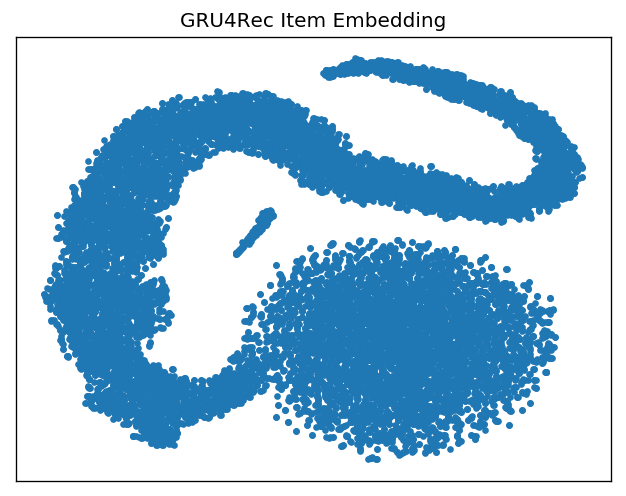

In [10]:
item_emb = model.output_items().numpy()
tsne_emb = TSNE(n_components=2).fit_transform(item_emb)
plot_embedding(tsne_emb,'GRU4Rec Item Embedding')

## 3.作者的总结

我们这里首先介绍了推荐系统的整体架构以及各部分的算法特点，这里着重介绍了召回算法的特点，接下来我们以GRU4Rec为例给大家把序列召回的全流程理清楚，最后给了大家一套完完整整可以跑的代码来让大家更加系统的理解这一套逻辑，希望大家认认真真的梳理这一套逻辑以及相关代码细节！

# 4.参考资料

* https://blog.csdn.net/Jericho2022/article/details/126556418
* https://blog.csdn.net/weixin_41403341/article/details/124602248